In [4]:
import pandas as pd
import numpy as np
data = pd.read_csv("raw_data.csv")
series_col = "Close_2330.TW"
exog_cols = [col for col in data.columns if col not in [series_col, "Date"]]
orig_dates = data.index.copy()
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date').sort_index()
full_index = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
data_full = data.reindex(full_index)
price_cols = [c for c in data_full.columns if 'Close' in c]
volume_cols = [c for c in data_full.columns if 'Volume' in c]
return_cols = [c for c in data_full.columns if 'Return' in c]
data_full = data_full.iloc[3:]
# If you want to mark weekends explicitly:
data_full[price_cols] = data_full[price_cols].ffill()
data_full[volume_cols] = data_full[volume_cols].fillna(0)
data_full[return_cols] = data_full[return_cols].fillna(0)
data_full['is_weekend'] = data_full.index.dayofweek >= 5
data = data_full
data = data.sort_index()
y = data[series_col]
x = data[exog_cols]
test_size = int(0.1*len(data))
y_train = y[:-test_size]
y_test = y[-test_size:]
x_train = x[:-test_size]
x_test = x[-test_size:]

In [ ]:
import optuna
from catboost import CatBoostRegressor
from skforecast.recursive import ForecasterRecursive
from skforecast.preprocessing import RollingFeatures

from sklearn.preprocessing import PowerTransformer
from skforecast.model_selection import TimeSeriesFold, backtesting_forecaster
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import warnings
from skforecast.exceptions import DataTypeWarning
warnings.simplefilter('ignore', category=DataTypeWarning)
warnings.simplefilter('ignore', category=ConvergenceWarning)

def objective(trial):
    # Suggest key CatBoost hyperparameters
    params = {
        'iterations': 500,
        'early_stopping_rounds': 50,
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 1e-2, 10.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'verbose': 0
    }

    forecaster = ForecasterRecursive(
                 regressor       = CatBoostRegressor(**params),
                 lags            = 8,
                 window_features = RollingFeatures(stats=['mean'], window_sizes=[15]),
                 transformer_y   = PowerTransformer(method="box-cox"))
    metrics = [
        # 'mean_absolute_error',
        'root_mean_squared_scaled_error',
        # 'mean_absolute_percentage_error',
        # 'mean_absolute_scaled_error'
    ]
    tscv = TimeSeriesFold(
        steps=30,                 # predict 30 days at a time
        initial_train_size=128,   # start with 1 year of data
        refit=True,
        window_size=10
    )
    backtest_metrics, predictions = backtesting_forecaster(
                                        forecaster = forecaster,
                                        y          = y_train,
                                        cv         = tscv,
                                        metric     = metrics,
                                        exog=x_train,
                                        show_progress=False)
    
    return backtest_metrics.values.item()

In [13]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

[I 2025-09-13 16:06:26,927] A new study created in memory with name: no-name-0cb8344a-d844-43e5-8369-1ab3e5ed1c22
[I 2025-09-13 16:06:35,121] Trial 0 finished with value: 3.6661487820968017 and parameters: {'depth': 6, 'learning_rate': 0.035952099662374726, 'l2_leaf_reg': 0.29155795460361195, 'bagging_temperature': 0.5628787990436062, 'random_strength': 0.047034314087101334, 'border_count': 178}. Best is trial 0 with value: 3.6661487820968017.
[I 2025-09-13 16:06:36,998] Trial 1 finished with value: 3.3923185288718862 and parameters: {'depth': 5, 'learning_rate': 0.012331036063022344, 'l2_leaf_reg': 0.229225285526085, 'bagging_temperature': 0.9936232595057126, 'random_strength': 1.081435311921746, 'border_count': 228}. Best is trial 1 with value: 3.3923185288718862.
[I 2025-09-13 16:06:41,623] Trial 2 finished with value: 3.620244755258759 and parameters: {'depth': 7, 'learning_rate': 0.17506906986925644, 'l2_leaf_reg': 0.60401853126812, 'bagging_temperature': 0.5907158804151387, 'rand

KeyboardInterrupt: 

In [72]:
forecaster.fit(y_train, x_train)
predictions = forecaster.predict(steps=len(y_test), exog=x_test[exog_cols])

Learning rate set to 0.036567
0:	learn: 102.4267772	total: 3.46ms	remaining: 3.45s
1:	learn: 99.3026563	total: 6.4ms	remaining: 3.19s
2:	learn: 96.4087772	total: 9.25ms	remaining: 3.07s
3:	learn: 93.5508763	total: 12.6ms	remaining: 3.13s
4:	learn: 90.8261432	total: 15.7ms	remaining: 3.13s
5:	learn: 88.0171479	total: 19.4ms	remaining: 3.21s
6:	learn: 85.5389670	total: 22.4ms	remaining: 3.18s
7:	learn: 82.9948508	total: 25.3ms	remaining: 3.14s
8:	learn: 80.5392791	total: 28.4ms	remaining: 3.13s
9:	learn: 78.3054158	total: 31.7ms	remaining: 3.14s
10:	learn: 75.9479711	total: 35ms	remaining: 3.15s
11:	learn: 73.8003469	total: 38.1ms	remaining: 3.14s
12:	learn: 71.7183242	total: 41.1ms	remaining: 3.12s
13:	learn: 69.6102021	total: 44.1ms	remaining: 3.11s
14:	learn: 67.5645138	total: 47.4ms	remaining: 3.11s
15:	learn: 65.6766105	total: 50.5ms	remaining: 3.11s
16:	learn: 63.9221019	total: 53.4ms	remaining: 3.08s
17:	learn: 62.2230756	total: 56.3ms	remaining: 3.07s
18:	learn: 60.5523775	total:

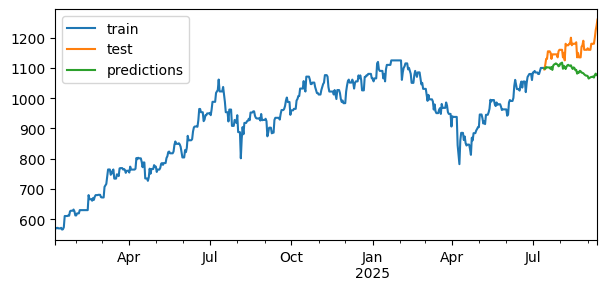

In [73]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7, 3))
y_train.plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()

In [115]:
from sklearn.metrics import root_mean_squared_error
y_true = data_test[series_col].values
y_pred = predictions.values
error = root_mean_squared_error(y_true, y_pred)
print(error)

5.933721189022128
